### Imports and environemnt setup

In [1]:
import utils 
import pandas as pd

import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import numpy as np

In [2]:
from_csv = False
csv_path = 'movies2.csv'
scaling_factor = 1000000

### Get data from API or load csv

In [3]:
if from_csv:
    movies_df = pd.read_csv(csv_path)
else:
    movies_dict = utils.get_movies_list(pages=10)
    all_movie_details = []
    for i in range(len(movies_dict)):
        movie_id = movies_dict[i]['id']
        movie_details = utils.get_movie_details(movie_id)
        # Create 3 features corresponding to 3 genres for the film
        genres_list = utils.get_top3_genres_features(movie_details['genres'].copy())
        movie_details['genre1'] = genres_list[0]
        movie_details['genre2'] = genres_list[1]
        movie_details['genre3'] = genres_list[2]
        # Avg similar films revenues
        movie_details['similar_revenues'] = utils.get_keywords_related_films_average_score(movie_id)
        # Crew popularity
        movie_details['crew_popularity'] = utils.crew_popularity(movie_id)
        # Top10 movie_cast pop
        cast = utils.get_movie_cast(movie_id=movie_id)
        popularities = [person['popularity'] for person in cast['cast']]
        total_popularity = np.sum(np.sort(popularities)[-10:])
        movie_details['top_cast_popularity'] = total_popularity
        # Add the row
        all_movie_details.append(movie_details)
    movies_df = pd.DataFrame(all_movie_details)

In [4]:
movies_df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,title,video,vote_average,vote_count,genre1,genre2,genre3,similar_revenues,crew_popularity,top_cast_popularity
0,False,/gkoq31q4fe9L1cCooZI5y61FlN7.jpg,None,800000000,"[{'id': 27, 'name': 'Horror'}, {'id': 10752, '...",https://m.youtube.com/watch?v=F-QGRigpYmw&pp=y...,1224207,None,en,Adventures in Bora Bora,...,Adventures in Bora Bora,False,0.000,0,27,10752,-1,0.000000e+00,0.600,3.000
1,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995,tt0499549,en,Avatar,...,Avatar,False,7.576,30236,28,12,14,2.100786e+08,34.920,235.832
2,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,en,Avengers: Endgame,...,Avengers: Endgame,False,8.259,24261,12,878,28,1.527896e+08,108.146,598.517
3,False,/8rpDcsfLJypbO6vREc0547VKqEv.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",460000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,76600,tt1630029,en,Avatar: The Way of Water,...,Avatar: The Way of Water,False,7.646,10510,878,12,28,3.877192e+08,39.730,319.243
4,False,/rzdPqYx7Um4FUZeD8wpXqjAUcEm.jpg,None,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.paramountmovies.com/movies/titanic,597,tt0120338,en,Titanic,...,Titanic,False,7.901,24037,18,10749,-1,2.384559e+07,24.207,256.265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,False,/vUTVUdfbsY4DePCYzxxDMXKp6v6.jpg,"{'id': 137696, 'name': 'Monsters, Inc. Collect...",115000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://movies.disney.com/monsters-inc,585,tt0198781,en,"Monsters, Inc.",...,"Monsters, Inc.",False,7.839,17484,16,35,10751,2.583530e+08,45.542,212.085
196,False,/uQNB6ccHv4uR21643xqyhK5Dk6W.jpg,None,70000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",,460555,tt6878882,zh,红海行动,...,Operation Red Sea,False,7.121,243,28,53,10752,1.444354e+08,10.032,79.250
197,False,/rwcPe582tfTSVLwQzbO25InW3Hi.jpg,"{'id': 85943, 'name': 'Night at the Museum Col...",110000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://family.20thcenturystudios.com/movies/n...,1593,tt0477347,en,Night at the Museum,...,Night at the Museum,False,6.576,9695,28,12,35,3.198363e+08,52.572,272.349
198,False,/psYeKwKclG4XaIop5suj1J0Kg2C.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",32350000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,1892,tt0086190,en,Return of the Jedi,...,Return of the Jedi,False,7.894,14821,12,28,878,1.210183e+08,38.240,165.819


In [5]:
if not from_csv:
    movies_df.to_csv('movies3.csv', index=False)

### Training a basic model

In [13]:
features = ['budget', 'genre1', 'genre2', 'genre3', 
            'popularity', 'runtime', 
            'vote_average', 'vote_count', 'similar_revenues',
            'crew_popularity', 'top_cast_popularity']
label = ['revenue']

In [14]:
movies_df = movies_df.dropna()

X = movies_df[features]
X[['budget', 'similar_revenues']] = X[['budget', 'similar_revenues']]/scaling_factor

y = movies_df[label]/scaling_factor

/home/julien/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
X['similar_revenues'].max()

555.0273016666666

In [18]:
y

,revenue
1,2923.706026
2,2800.000000
3,2320.250281
5,2068.223624
6,2052.415039
...,...
194,585.174222
195,579.700000
197,574.480841
198,572.700000


In [21]:
model = KNeighborsRegressor(n_neighbors= 10)
# model = RadiusNeighborsRegressor(radius= 10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = model.fit(X_train, y_train)

# Evaluate on training set
y_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Training set scores: mse %f, mae %f, r2 %f" % (mse, mae, r2))

# Evaluate on test set
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set scores: mse %f, mae %f, r2 %f" % (mse, mae, r2))


Training set scores: mse 104172.356401, mae 220.864752, r2 0.181088
Test set scores: mse 136397.016191, mae 239.209677, r2 0.133595


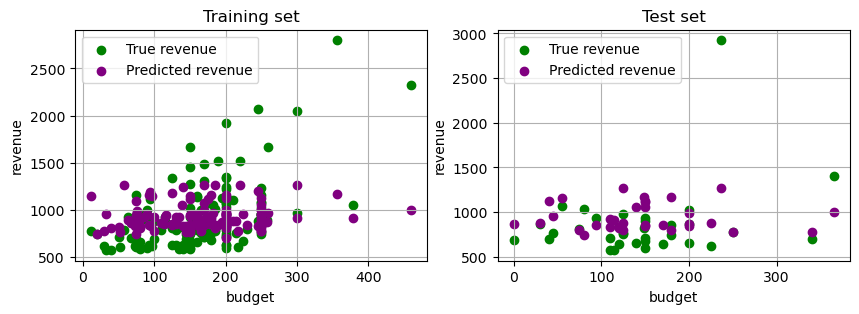

In [22]:
f, ax = plt.subplots(1, 2,figsize=(10, 3))
ax[0].scatter(X_train[['budget']], y_train, color='green')
ax[0].scatter(X_train[['budget']], reg.predict(X_train), color='purple')
ax[0].set_title('Training set')
ax[0].set_xlabel('budget')
ax[0].set_ylabel('revenue')
ax[0].legend(['True revenue', 'Predicted revenue'])
ax[0].grid()
ax[1].scatter(X_test[['budget']], y_test, color='green')
ax[1].scatter(X_test[['budget']], reg.predict(X_test), color='purple')
ax[1].set_title('Test set')
ax[1].set_xlabel('budget')
ax[1].set_ylabel('revenue')
ax[1].legend(['True revenue', 'Predicted revenue'])
ax[1].grid()

plt.show()

# plt.scatter(X_train, y_train, color='green')
# plt.scatter(X_train, reg.predict(X_train), color='purple')